In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
         
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 导入数据

In [2]:
df_train = pd.read_csv('train.csv', header=None)
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/4d8a38b29930a403e5...,collar_design_labels,nnynn
1,Images/collar_design_labels/bd0981f231180d2b00...,collar_design_labels,nynnn
2,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn
3,Images/collar_design_labels/cf4140ec542887270f...,collar_design_labels,nynnn
4,Images/collar_design_labels/50644b2b9de045f2d1...,collar_design_labels,nynnn


In [3]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels', 
           'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels', 
           'pant_length_labels']
len(classes)

8

### 加载数据

In [4]:
cur_class = classes[0]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

collar_design_labels: 8393


,image_id,class,label
0,Images/collar_design_labels/4d8a38b29930a403e5...,collar_design_labels,nnynn
1,Images/collar_design_labels/bd0981f231180d2b00...,collar_design_labels,nynnn
2,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn
3,Images/collar_design_labels/cf4140ec542887270f...,collar_design_labels,nynnn
4,Images/collar_design_labels/50644b2b9de045f2d1...,collar_design_labels,nynnn


In [5]:
df_load[(df_load.index == 2)]

,image_id,class,label
2,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn


In [6]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299

X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)

for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
    if len(tmp_label) > n_class:
        print(df_load['image_id'][i])
    X[i] = cv2.resize(cv2.imread('./train/{0}'.format(df_load['image_id'][i])), (width, width))
    y[i][tmp_label.find('y')] = 1

100%|██████████| 8393/8393 [02:06<00:00, 66.47it/s]


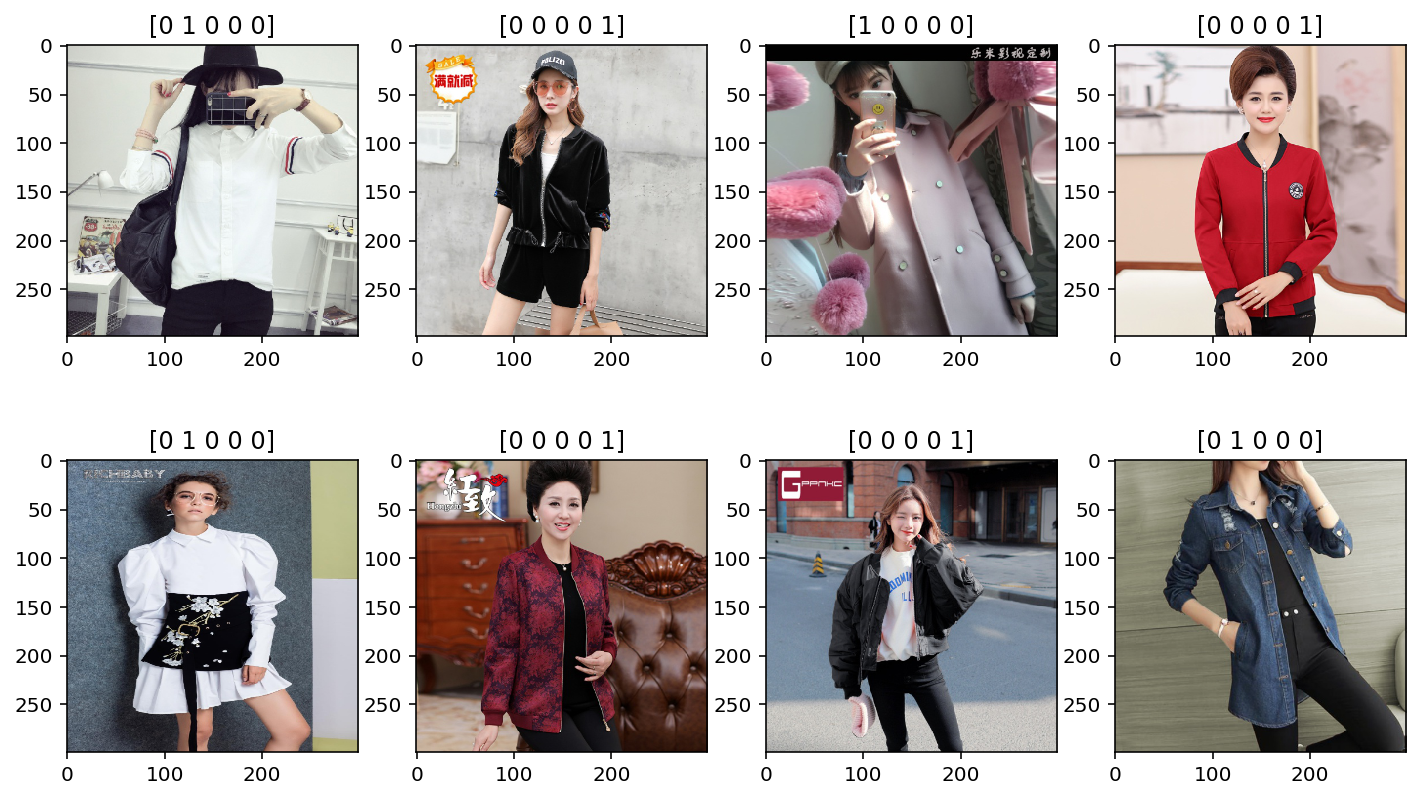

In [8]:
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = np.random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(y[random_index])

### 提取特征

In [8]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
cnn_model = InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

### 划分训练、测试集

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.12, random_state=42)
X_train.shape, y_train.shape

((7385, 299, 299, 3), (7385, 5))

In [11]:
adam = Adam(lr=0.001)
prefix_cls = cur_class.split('_')[0]

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='./models/{0}.best.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

h = model.fit(X_train, y_train, batch_size=32, epochs=80, 
              callbacks=[EarlyStopping(patience=3), checkpointer], 
              shuffle=True, 
              validation_split=0.1)

Train on 6646 samples, validate on 739 samples
Epoch 1/80
6646/6646 [==============================] - 196s 29ms/step - loss: 0.9367 - acc: 0.6539 - val_loss: 1.1038 - val_acc: 0.6766
Epoch 2/80
6646/6646 [==============================] - 183s 27ms/step - loss: 0.6077 - acc: 0.7880 - val_loss: 0.7560 - val_acc: 0.7361
Epoch 3/80
6646/6646 [==============================] - 181s 27ms/step - loss: 0.4264 - acc: 0.8554 - val_loss: 1.5847 - val_acc: 0.5372
Epoch 4/80
6646/6646 [==============================] - 181s 27ms/step - loss: 0.3444 - acc: 0.8816 - val_loss: 0.8974 - val_acc: 0.7294
Epoch 5/80
6646/6646 [==============================] - 181s 27ms/step - loss: 0.2420 - acc: 0.9180 - val_loss: 1.4803 - val_acc: 0.6455


Text(0.5,0,'epoch')

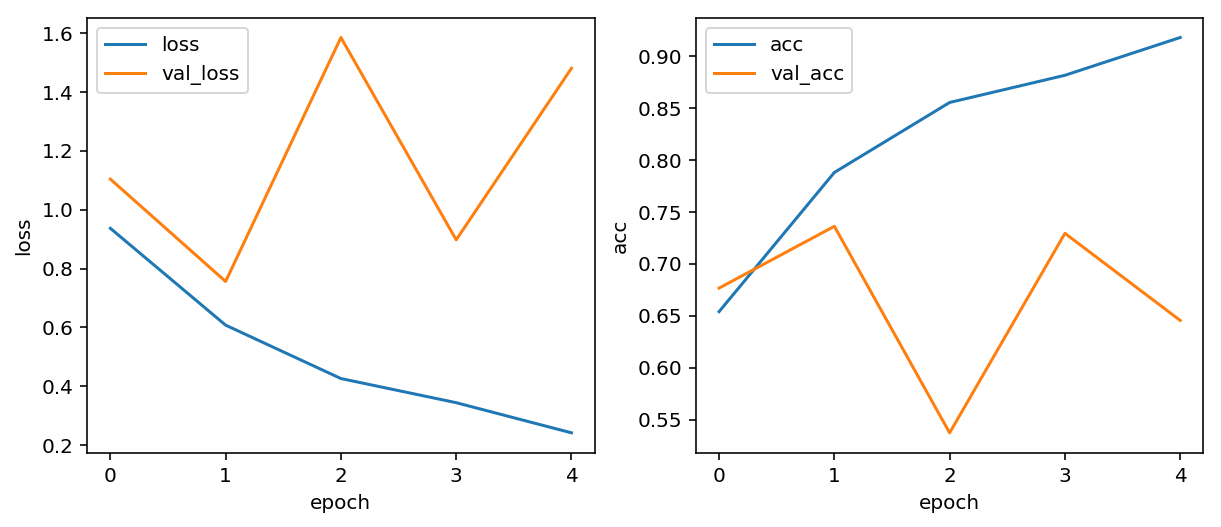

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [14]:
model.evaluate(X_train, y_train, batch_size=256)

7385/7385 [==============================] - 62s 8ms/step


[0.7887161796288307, 0.7599187538037853]

In [15]:
model.evaluate(X_valid, y_valid, batch_size=256)

1008/1008 [==============================] - 9s 9ms/step


[1.4538595203369382, 0.6448412698412699]

### 加载测试集

In [16]:
df_test = pd.read_csv('test_a.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/60951f5761ea3a01d6...,collar_design_labels
1,Images/collar_design_labels/677e1183282769a3fe...,collar_design_labels
2,Images/collar_design_labels/3f5a2be205e5d253eb...,collar_design_labels
3,Images/collar_design_labels/1712bf3d7b57d779ad...,collar_design_labels
4,Images/collar_design_labels/0b2b4254f35ce3a41a...,collar_design_labels


In [17]:
df_load = df_test[(df_test['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

collar_design_labels: 1082


,image_id,class
0,Images/collar_design_labels/60951f5761ea3a01d6...,collar_design_labels
1,Images/collar_design_labels/677e1183282769a3fe...,collar_design_labels
2,Images/collar_design_labels/3f5a2be205e5d253eb...,collar_design_labels
3,Images/collar_design_labels/1712bf3d7b57d779ad...,collar_design_labels
4,Images/collar_design_labels/0b2b4254f35ce3a41a...,collar_design_labels


In [18]:
n = len(df_load)
X_test = np.zeros((n, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('./test_a/{0}'.format(df_load['image_id'][i])), (width, width))

100%|██████████| 1082/1082 [00:04<00:00, 265.47it/s]


In [19]:
test_np = model.predict(X_test, batch_size=256)

In [20]:
test_np.shape

(1082, 5)

In [21]:
result = []

for i, row in df_load.iterrows():
    tmp_list = test_np[i]
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load['result'] = result
df_load.head()

,image_id,class,result
0,Images/collar_design_labels/60951f5761ea3a01d6...,collar_design_labels,0.0008;0.9845;0.0005;0.0141;0.0001
1,Images/collar_design_labels/677e1183282769a3fe...,collar_design_labels,0.0000;0.0000;0.0000;1.0000;0.0000
2,Images/collar_design_labels/3f5a2be205e5d253eb...,collar_design_labels,0.0000;0.9998;0.0000;0.0002;0.0000
3,Images/collar_design_labels/1712bf3d7b57d779ad...,collar_design_labels,0.0056;0.0004;0.0087;0.9846;0.0007
4,Images/collar_design_labels/0b2b4254f35ce3a41a...,collar_design_labels,0.0000;0.0000;0.0002;0.9998;0.0000


In [22]:
df_load.to_csv('./result/{}_0307a.csv'.format(prefix_cls), header=None, index=False)
prefix_cls

'collar'